In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets
import pathlib
import pandas as pd
from scipy.stats import binned_statistic_2d
from functions import *

# Import and read the dataframe from cn04 

In [2]:
# ! scp cn04:/home/astro/heitzman/SAA_mapping/all_data.pkl /Users/alexisheitzmann/Documents/CHEOPS/Code/SAA_monitoring_MC/SAA_ORs_reduction_pipeline/ .

# Set up main directory

In [3]:
mainPath = pathlib.Path("/home/lui/Documents/thesis/CheopsCosmics/Pipeline_new/SAA_ORs_reduction_pipeline_v_0.1.0/SAA_ORs_reduction_pipeline_v_0.1.0")

In [17]:
visit_type = 'science'
#visit_type = 'SAA'
file_name = "all_data_" + visit_type + ".pkl"
data_file = mainPath / file_name
all_data = pd.read_pickle(data_file)

In [18]:
def plot_function(data_to_plot, title):
    
    def plotimg(idx):
        # Update histogram
        ax[0].clear()
        ax[0].hist(data_to_plot[int(idx)].flatten(), bins = len(np.unique(data_to_plot[int(idx)].flatten())))
        # Update image
        img.set_data(data_to_plot[int(idx),:,:])
        im = ax[1].imshow(data_to_plot[int(idx),:,:], origin='lower', cmap = 'viridis')
        ax[0].axvline(np.nanmedian(data_to_plot[int(idx),:,:]), c = 'r',  alpha = 0.5) # median pixel value
        ax[0].axvline(np.nanmean(data_to_plot[int(idx),:,:]), c = 'g', alpha = 0.5) # mean pixel value
        #plt.colorbar(im)
        fig.canvas.draw_idle()
        
    fig, ax = plt.subplots(ncols = 2, figsize=(12,4))
    img = ax[1].imshow(data_to_plot[0], origin='lower')
    #colorbar = plt.colorbar(img)
    ax[0].set_xlabel('Brightness')
    ax[0].set_ylabel('Nb of pixels')
    plt.suptitle(title, weight = 'bold')

    ipywidgets.interact(plotimg, idx = ipywidgets.FloatSlider(value=0,min=0,max=np.shape(data_to_plot)[0]-1,step=1))
    plt.show()

# Detections

In [19]:
if len(np.unique(all_data['im_height'])) > 1:
    diff_image_types = True # We have different image sizes in all_data
    print(f"Sizes available are {np.unique(all_data['im_height'])}")
else:
    diff_image_types = False

# Filters

In [20]:
# DETECTIONS 
detections = all_data[all_data['nb_cosmics'] != 0]
#detections = all_data[(all_data['density_cosmics'] < 60) & (all_data['density_cosmics'] > 40)]
non_detections = all_data[all_data['nb_cosmics'] == 0]

# FILTER TO IDENTIFY EXTREMELY LARGE COSMICS, SIGN OF BAD IMAGE
nb_pixels_max_cosmic = np.array([])
visit = np.array([])

for i in range(len(detections)):
    nb_pixels_cosmic = []
    det = detections.iloc[i]
    for cosmic in det['pix_cosmics']:
        nb_pixels_cosmic.append(np.shape(cosmic)[0])
    nb_pixels_max_cosmic = np.append(nb_pixels_max_cosmic,np.max(nb_pixels_cosmic))
    visit = np.append(visit, str(det['visit_ID']) + '_' + str(det['img_counter']))
    
# nb_pixels larger cosmic
non_detections = pd.concat([non_detections,detections.iloc[np.where(nb_pixels_max_cosmic > 50)]])
detections = detections.iloc[np.where(nb_pixels_max_cosmic < 50)]

max_cosmics = np.max(detections['nb_cosmics'])
max_density = np.max(detections['density_cosmics'])

print(f'Frame with most cosmics has {max_cosmics} cosmics. largest density is {int(max_density)} hits/cm2/sec')
print(f"{int(len(detections)/len(all_data)*100)}% of visits ({len(detections)}/{len(all_data)}) have detections. {int(len(non_detections))} non detections")



Frame with most cosmics has 162 cosmics. largest density is 70 hits/cm2/sec
55% of visits (5074/9086) have detections. 4011 non detections


## Separate sizes of images

In [21]:
if diff_image_types:
    size_to_keep = 200
    detections_plot = detections[detections['im_height'] == size_to_keep]
    non_detections_plot = non_detections[non_detections['im_height'] == size_to_keep]
    print(f"!! Only images of sizes {size_to_keep}*{size_to_keep} are shown !!\n")
else:     
    detections_plot = detections
    non_detections_plot = non_detections
    
## Add other filters 


       
# latitude
filt_lat_det = detections['LATITUDE'] < -60
filt_lat_nondet = non_detections['LATITUDE'] < -60

# visit_ID
ID_to_filter = '14_9002_13_1'
filt_ID_det = detections['visit_ID'] == ID_to_filter
filt_ID_nondet = non_detections['visit_ID'] == ID_to_filter

# cosmic density
filt_density_det = detections['density_cosmics'] > 50
filt_density_nondet = non_detections['density_cosmics'] < 50

# stacking order
filt_stack_det = detections['n_exp'] > 1
filt_stack_nondet = detections['n_exp'] > 1


#detections_plot = detections_plot[
#                                        filt_lat_det &
#                                        filt_ID_det &
#                                        filt_density_det
#                                         filt_large_cr_det
#                                         filt_stack_det
#                                      ]

# non_detections_plot = non_detections_plot[
#                                         # filt_lat_nondet &
#                                         filt_ID_nondet
#                                         # filt_density_nondet &
#                                         # filt_stack_nondet
#                                         ]




interactive(children=(FloatSlider(value=0.0, description='idx', max=5073.0, step=1.0), Output()), _dom_classes…

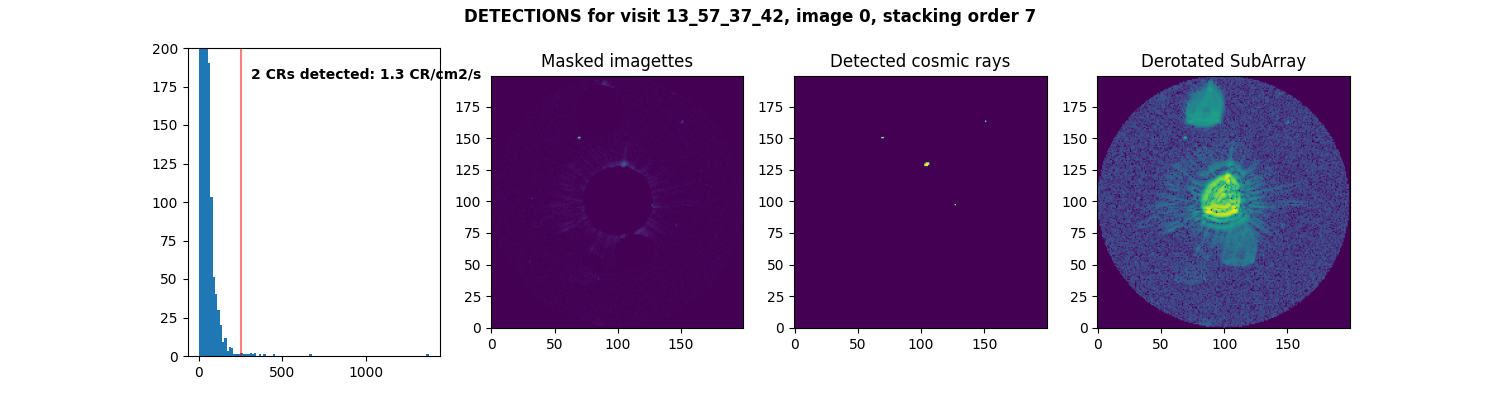

In [22]:
data_to_plot1 = reshape_flatten_images('masked_images', detections_plot) 
data_to_plot2 = reshape_flatten_images('binary_images', detections_plot) 
data_to_plot3 = reshape_flatten_images('derotated_images', detections_plot) 
data_to_plot3 = np.log(data_to_plot3+1)
visit_id = detections_plot['visit_ID'].values
stacking_order = detections_plot['n_exp'].values
image_counter = detections_plot['img_counter'].values
threshold_cosmics = np.unique(detections_plot['threshold_cosmics'])
cosmics = detections_plot['nb_cosmics'].values
density_cosmics = detections_plot['density_cosmics'].values

def plotimg(idx):
    
    # Update histogram
    ax[0].clear()
    ax[0].hist(data_to_plot1[int(idx)].flatten(), bins = 100)#int(np.max(data_to_plot1[int(idx)].flatten())))
    #ax[0].set_xlim(0,100)
    ax[0].set_ylim(0,200)
    # Update image
    img1.set_data(data_to_plot1[int(idx)])
    img2.set_data(data_to_plot2[int(idx)])
    img3.set_data(data_to_plot3[int(idx)])
    ax[1].imshow(data_to_plot1[int(idx)], origin='lower', cmap = 'viridis')
    ax[2].imshow(data_to_plot2[int(idx)], origin='lower', cmap = 'viridis')
    ax[3].imshow(data_to_plot3[int(idx)], origin='lower', cmap = 'viridis')
    ax[0].axvline(threshold_cosmics, c = 'r',  alpha = 0.5) # median pixel value
    ax[0].text(0.25,0.9,f'{int(cosmics[int(idx)])} CRs detected: {np.round(density_cosmics[int(idx)],1)} CR/cm2/s', weight = 'bold', transform=ax[0].transAxes)
    fig.suptitle(f'DETECTIONS for visit {visit_id[int(idx)]}, image {image_counter[int(idx)]}, stacking order {stacking_order[int(idx)]}', weight = 'bold')
    #plt.colorbar(im)
    fig.canvas.draw_idle()
    
fig, ax = plt.subplots(ncols = 4, figsize=(15,4))
img1 = ax[1].imshow(data_to_plot1[0], origin='lower')
ax[1].set_title('Masked imagettes')
img2 = ax[2].imshow(data_to_plot2[0], origin='lower')
ax[2].set_title('Detected cosmic rays')
img3 = ax[3].imshow(data_to_plot3[0], origin='lower')
ax[3].set_title('Derotated SubArray')
#colorbar = plt.colorbar(img)
ax[0].set_xlabel('Brightness')
ax[0].set_ylabel('Nb of pixels')

fig.suptitle(f'DETECTIONS for visit {visit_id[0]}, image {image_counter[0]}, stacking order {stacking_order[0]}', weight = 'bold')
ipywidgets.interact(plotimg, idx = ipywidgets.FloatSlider(value=0,min=0,max=np.shape(data_to_plot1)[0]-1,step=1))
plt.show()

# Non detections

interactive(children=(FloatSlider(value=0.0, description='idx', max=127.0, step=1.0), Output()), _dom_classes=…

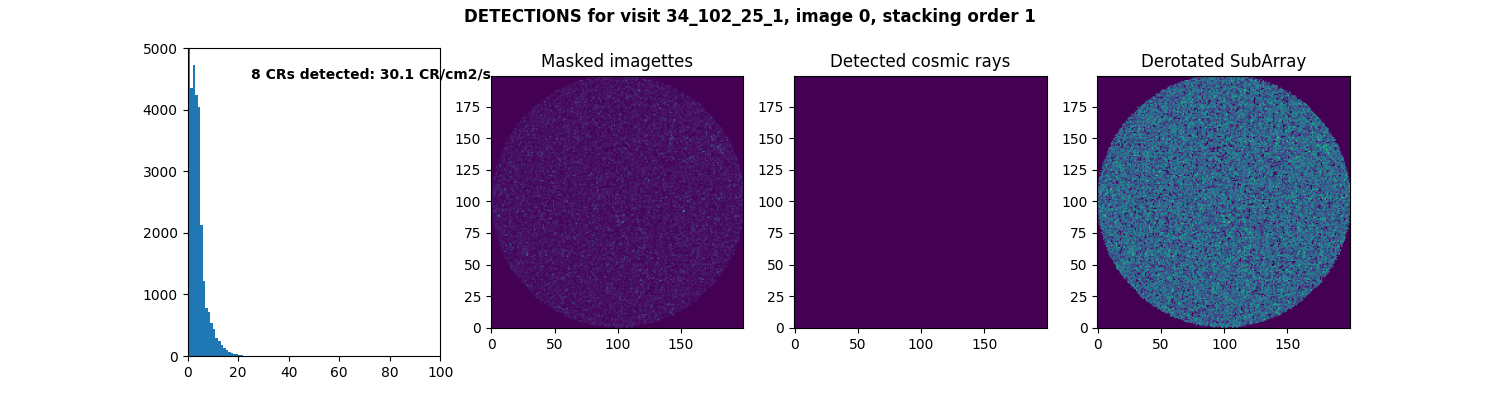

In [10]:
data_to_plot1 = reshape_flatten_images('masked_images', non_detections_plot) 
data_to_plot2 = reshape_flatten_images('binary_images', non_detections_plot) 
data_to_plot3 = reshape_flatten_images('derotated_images', non_detections_plot) 
data_to_plot3 = np.log(data_to_plot3+1)
visit_id = detections_plot['visit_ID'].values
stacking_order = detections_plot['n_exp'].values
image_counter = detections_plot['img_counter'].values
threshold_cosmics = np.unique(detections_plot['threshold_cosmics'])
cosmics = detections_plot['nb_cosmics'].values
density_cosmics = detections_plot['density_cosmics'].values

def plotimg(idx):
    
    # Update histogram
    ax[0].clear()
    ax[0].hist(data_to_plot1[int(idx)].flatten(), bins = max(int(np.max(data_to_plot1[int(idx)].flatten())),1))
    ax[0].set_xlim(0,100)
    ax[0].set_ylim(0,5000)
    # Update image
    img1.set_data(data_to_plot1[int(idx)])
    img2.set_data(data_to_plot2[int(idx)])
    img3.set_data(data_to_plot3[int(idx)])
    ax[1].imshow(data_to_plot1[int(idx)], origin='lower', cmap = 'viridis')
    ax[2].imshow(data_to_plot2[int(idx)], origin='lower', cmap = 'viridis')
    ax[3].imshow(data_to_plot3[int(idx)], origin='lower', cmap = 'viridis')
    ax[0].axvline(threshold_cosmics, c = 'r',  alpha = 0.5) # median pixel value
    ax[0].text(0.25,0.9,f'{int(cosmics[int(idx)])} CRs detected: {np.round(density_cosmics[int(idx)],1)} CR/cm2/s', weight = 'bold', transform=ax[0].transAxes)
    #plt.colorbar(im)    
    fig.suptitle(f'DETECTIONS for visit {visit_id[int(idx)]}, image {image_counter[int(idx)]}, stacking order {stacking_order[int(idx)]}', weight = 'bold')
    fig.canvas.draw_idle()
    
fig, ax = plt.subplots(ncols = 4, figsize=(15,4))
img1 = ax[1].imshow(data_to_plot1[0], origin='lower')
ax[1].set_title('Masked imagettes')
img2 = ax[2].imshow(data_to_plot2[0], origin='lower')
ax[2].set_title('Detected cosmic rays')
img3 = ax[3].imshow(data_to_plot3[0], origin='lower')
ax[3].set_title('Derotated SubArray')
#colorbar = plt.colorbar(img)
ax[0].set_xlabel('Brightness')
ax[0].set_ylabel('Nb of pixels')

fig.suptitle(f'DETECTIONS for visit {visit_id[0]}, image {image_counter[0]}, stacking order {stacking_order[0]}', weight = 'bold')
ipywidgets.interact(plotimg, idx = ipywidgets.FloatSlider(value=0,min=0,max=np.shape(data_to_plot1)[0]-1,step=1))
plt.show()

# Inspect latitude and longitude

In [11]:
# if type_of_visit == 'SAA':
#     resituted_orbit = pd.read_pickle('/Users/alexisheitzmann/Documents/CHEOPS/Code/SAA_monitoring_MC/restituted_orbit.pkl')
#     fig, ax = plt.subplots(ncols = 2, figsize=(12,4))
#     ax[0].plot(resituted_orbit.index,resituted_orbit['LATITUDE'], '.', label = 'restituted orbit')
#     ax[0].plot(detections.index,detections['LATITUDE'], '.', label = 'imagettes')
#     ax[0].set_title('LATITUDE')
#     ax[1].plot(resituted_orbit.index,resituted_orbit['LONGITUDE'], '.', label = 'restituted orbit')
#     ax[1].plot(detections.index,detections['LONGITUDE'], '.', label = 'imagettes')
#     ax[1].set_title('LONGITUDE')
# else:
#     print('science visits, no interpolation of orbit')

# MAP

In [12]:
import cartopy.crs as ccrs
import matplotlib
from astropy.io import fits
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd

In [13]:
# Read SAA mask
SAA_file = mainPath / "ref_files" / "CH_TU2024-01-16T15-06-00_EXT_APP_SAAMap-690km_V0301.fits"
data_SAA = read_SAA_map(SAA_file)

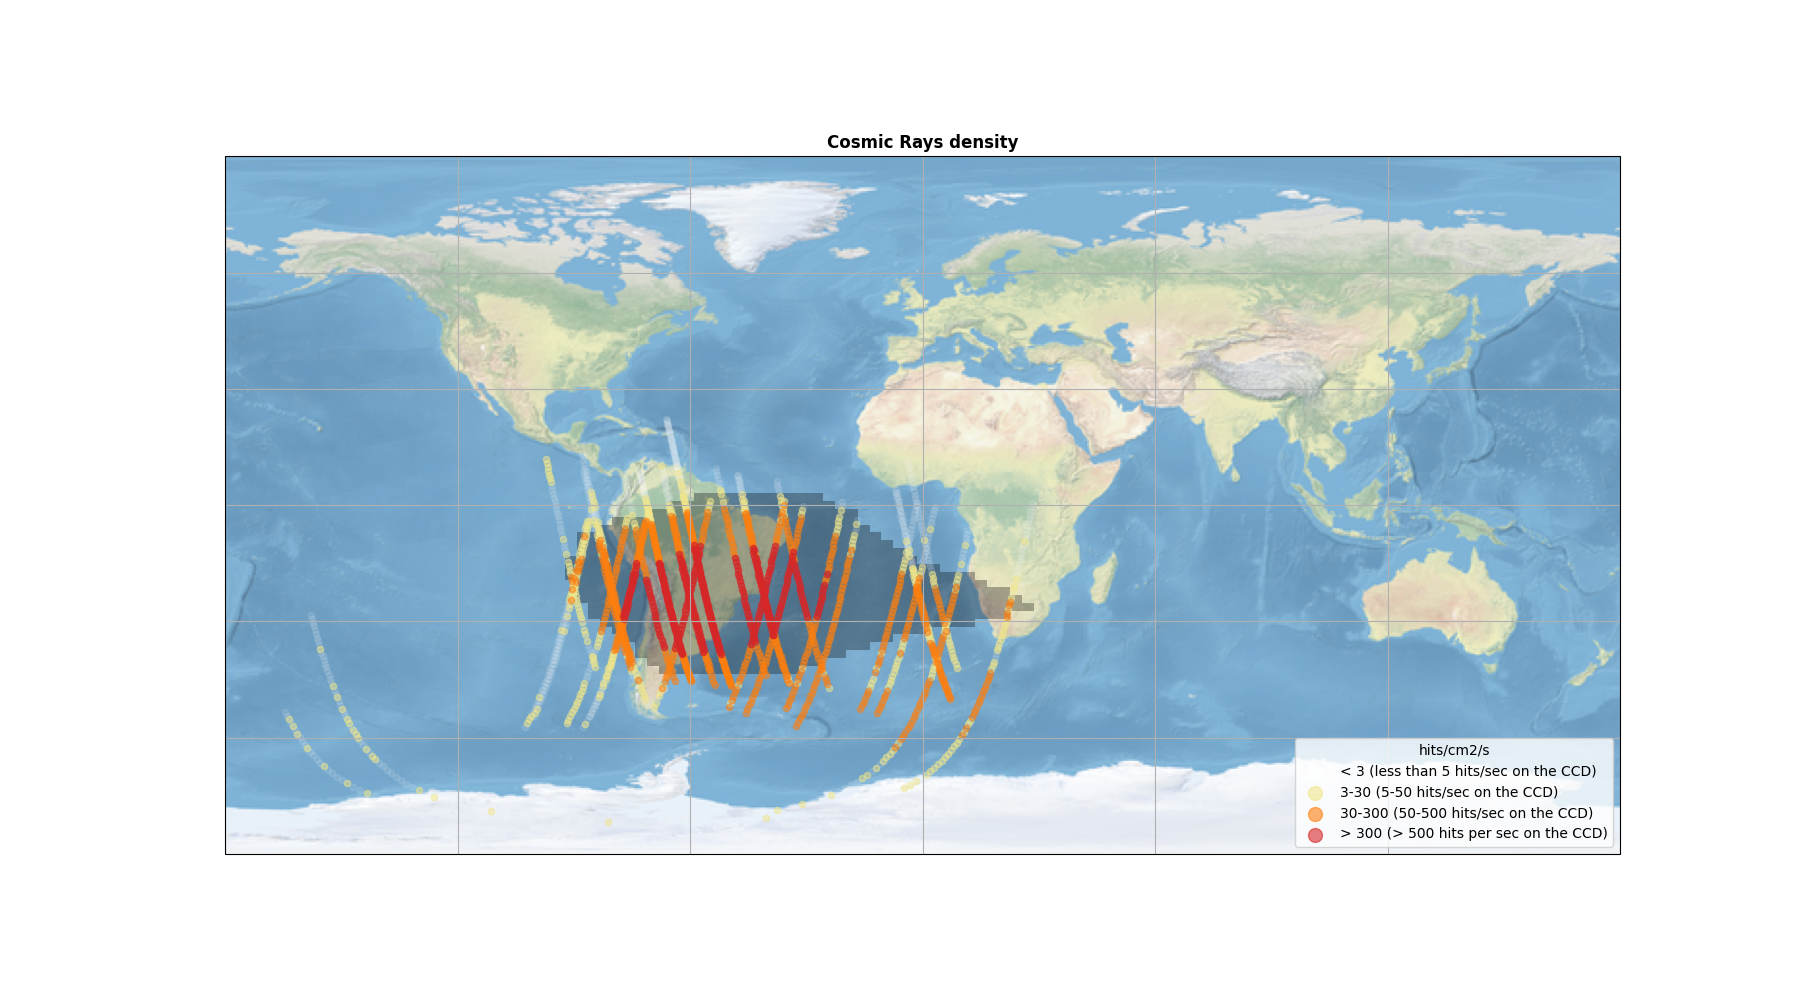

In [14]:
#%matplotlib widget
plt.close('all')
fig = plt.figure(figsize=(18, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax = plt.axes(projection=ccrs.Orthographic(-45, -23))
ax.stock_img()
ax.gridlines()


data_plot = all_data


lon_min, lon_max = -180, 180
lat_min, lat_max = -90, 90

# Plot SAA mask
x = data_SAA['longitude']
y = data_SAA['latitude']
c = data_SAA['SAA_FLAG']
#cc = plt.scatter(x,y,c = c, s = 100, alpha = 0.1, marker = 'o', edgecolor='none', transform=ccrs.Geodetic())

SAA_map_bins_lon = 3
SAA_map_bins_lat = 2
x_bins_SAA = np.arange(lon_min, lon_max,SAA_map_bins_lon)
y_bins_SAA = np.arange(lat_min, lat_max,SAA_map_bins_lat)

ret_SAA = binned_statistic_2d(x, y, c, statistic='median', bins=[x_bins_SAA, y_bins_SAA])
cmap = ListedColormap(['none', 'black'])
SAA_mask = ax.imshow(ret_SAA.statistic.T, origin='lower', cmap = cmap, alpha = 0.3, extent=(lon_min, lon_max, lat_min, lat_max)) # Supported values for interplotation are 'none', 'antialiased', 'nearest', 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos', 'blackman'.


# x = data_plot['LONGITUDE']
# y = data_plot['LATITUDE']
# c = np.log(data_plot['density_cosmics'])

# cr = plt.scatter(x,y,c = c, s = 20, alpha = 0.5, marker = '.', transform=ccrs.Geodetic())#, label = labels[i])
# plt.colorbar(cr)


labels = ['< 3 (less than 5 hits/sec on the CCD) ','3-30 (5-50 hits/sec on the CCD) ','30-300 (50-500 hits/sec on the CCD) ', '> 300 (> 500 hits per sec on the CCD)']
colors = ['white','khaki','C1','C3']
cm = ListedColormap(colors)
for i in range(4):
    if i == 0:
        x = data_plot.loc[data_plot['density_cosmics'] < 3]['LONGITUDE']
        y = data_plot.loc[data_plot['density_cosmics'] < 3]['LATITUDE']
        alpha = 0.1
        
    if i == 1:
        x = data_plot.loc[(data_plot['density_cosmics'] > 3) & (data_plot['density_cosmics'] < 30)]['LONGITUDE']
        y = data_plot.loc[(data_plot['density_cosmics'] > 3) & (data_plot['density_cosmics'] < 30)]['LATITUDE']
        alpha = 0.5
        
    if i == 2:
        x = data_plot.loc[(data_plot['density_cosmics'] >= 30) & (data_plot['density_cosmics'] < 300)]['LONGITUDE']
        y = data_plot.loc[(data_plot['density_cosmics'] >= 30) & (data_plot['density_cosmics'] < 300)]['LATITUDE']
        alpha = 0.5
    
        
    if i == 3:
        x = data_plot.loc[data_plot['density_cosmics'] >= 300]['LONGITUDE']
        y = data_plot.loc[data_plot['density_cosmics'] >= 300]['LATITUDE']
        alpha = 0.7
    
    cr = plt.scatter(x,y,c = colors[i], s = 20, alpha = alpha, marker = 'o', transform=ccrs.Geodetic(), label = labels[i])

handles = [
    plt.scatter([], [], s=100, c=colors[0], alpha=0.6, label=labels[0]),
    plt.scatter([], [], s=100, c=colors[1], alpha=0.6, label=labels[1]),
    plt.scatter([], [], s=100, c=colors[2], alpha=0.6, label=labels[2]),
    plt.scatter([], [], s=100, c=colors[3], alpha=0.6, label=labels[3]),

]

# Add legend to the plot with custom background color
legend = plt.legend(handles=handles, title="hits/cm2/s", loc='lower right')
legend.get_frame().set_facecolor('white')    
    
#     cm = ListedColormap(colors)
#     c = data_plot['multi_CRs']
#     plt.colorbar(cr)    
    
# x = data_plot['LONGITUDE']
# y = data_plot['LATITUDE']
# c = data_plot['nb_cosmics']
# cr = plt.scatter(x,y,c = c, alpha = 1, marker = '.', transform=ccrs.Geodetic())
# plt.colorbar(cr)

#labels = ['1 CR','multiple CR']
#colors = ['lightgrey', 'indianred']
# for i, value in enumerate([0,1]):
    # x = data_plot.loc[data_plot['multi_CRs'] == value]['LONGITUDE']
    # y = data_plot.loc[data_plot['multi_CRs'] == value]['LATITUDE']
    #cm = matplotlib.colormaps['tab10']
    #colors = ['lightgrey', 'indianred']
    #cm = ListedColormap(colors)
    #c = data_plot['multi_CRs']
    # plt.scatter(x,y,c = colors[i], s = 25, alpha = 1, marker = '.', transform=ccrs.Geodetic(), label = labels[i])
    #plt.colorbar(label='1 CR vs multiple CRs') 

# plt.legend(frameon=True,bbox_to_anchor=(0.12,0.6),markerscale=2)

# #plt.colorbar(aaa)
# #plt.title('June 28th, at 08:40:00, SAA_FLAG is False in MPS_PRE_VISIT')
# #plt.legend(frameon=True,bbox_to_anchor=(0.7,0),markerscale=1)
# #save_folder = '/Users/alexisheitzmann/Documents/CHEOPS/Code/SSA_mismapping/imagette_mapping/AU_Mic_5_sec_visits/'
# name_addition = 'all'
# save_name = 'map_CR_detections_'+ name_addition + '_' + np.min(full_orb_res_err.index).strftime("%Y-%m-%d") + '_to_' + np.max(full_orb_res_err.index).strftime("%Y-%m-%d") + '.png'
# title = str(len(data_plot)) + ' detections from ' + np.min(full_orb_res_err.index).strftime("%Y-%m-%d") + ' to ' + np.max(full_orb_res_err.index).strftime("%Y-%m-%d")
title = 'Cosmic Rays density'
plt.title(title, weight = 'bold')
plt.savefig("CR_density_" + visit_type + "_visits_discrete.png", transparent = True, dpi = 600,format = 'png')
# plt.savefig(save_name, transparent = True, dpi = 600,format = 'png')
# #plt.show()

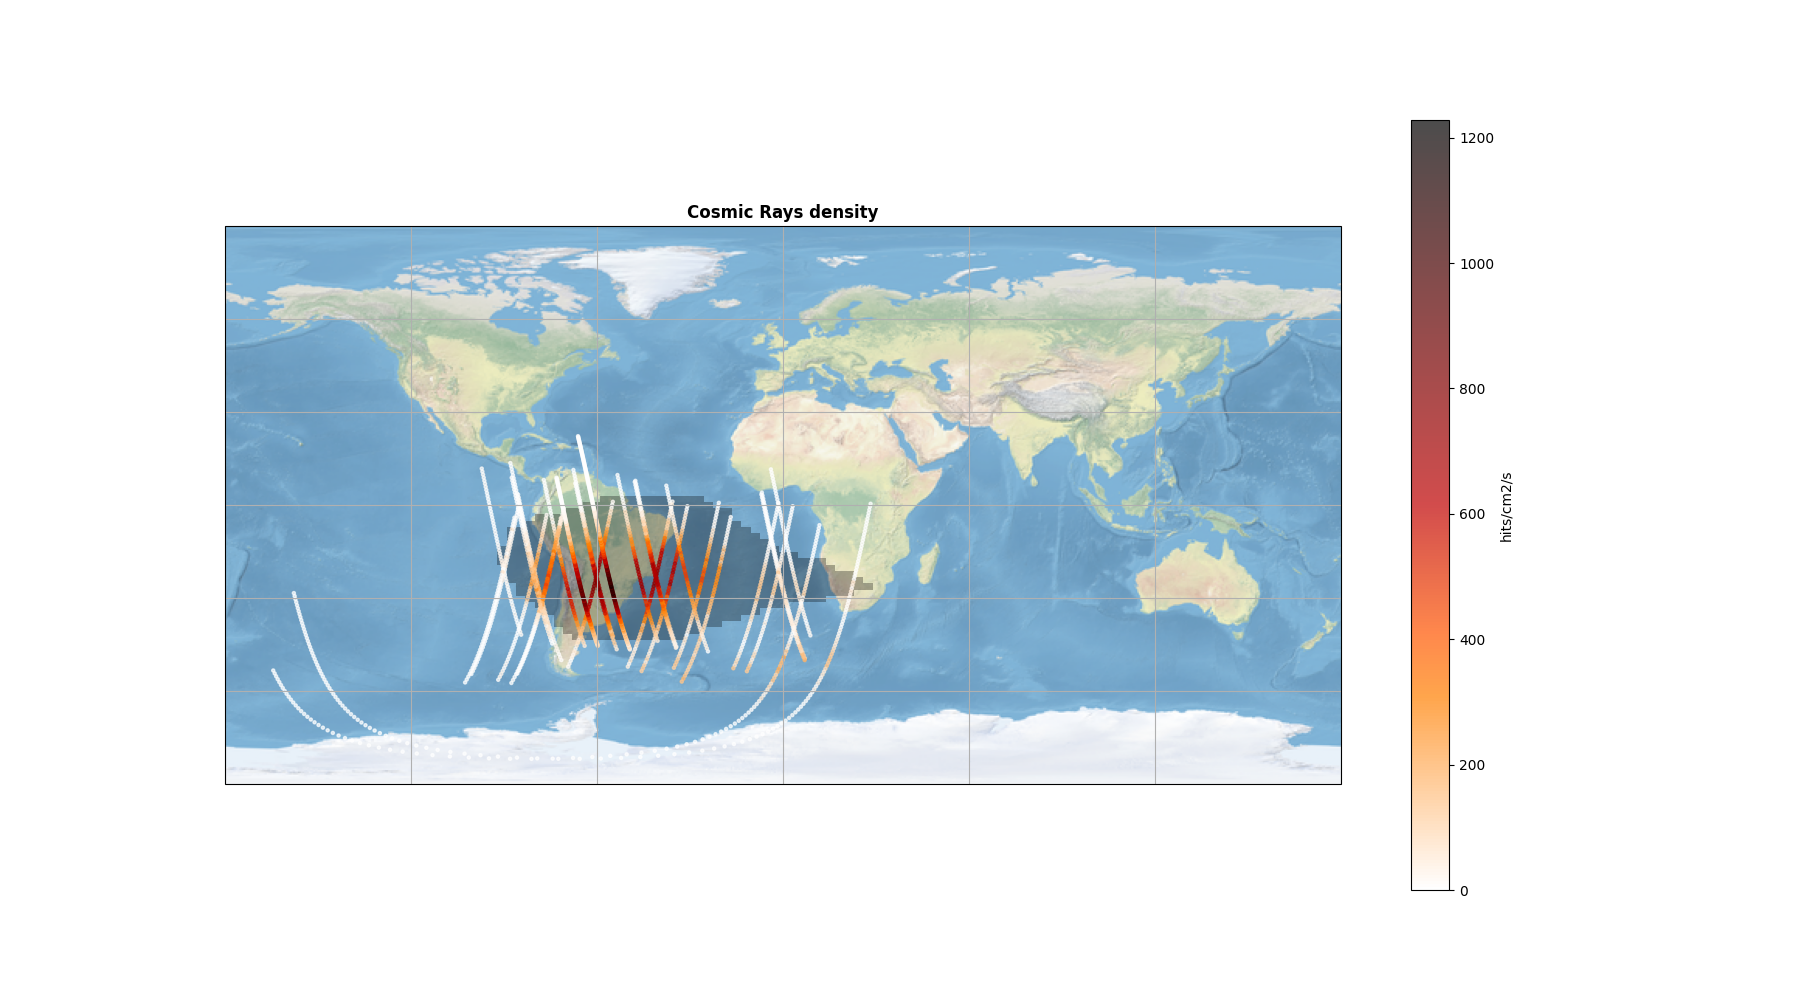

In [15]:
#%matplotlib widget
plt.close('all')
fig = plt.figure(figsize=(18, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax = plt.axes(projection=ccrs.Orthographic(-45, -23))
ax.stock_img()
ax.gridlines()


data_plot = all_data

lon_min, lon_max = -180, 180
lat_min, lat_max = -90, 90

# Plot SAA mask
x = data_SAA['longitude']
y = data_SAA['latitude']
c = data_SAA['SAA_FLAG']
#cc = plt.scatter(x,y,c = c, s = 100, alpha = 0.1, marker = 'o', edgecolor='none', transform=ccrs.Geodetic())

SAA_map_bins_lon = 3
SAA_map_bins_lat = 2
x_bins_SAA = np.arange(lon_min, lon_max,SAA_map_bins_lon)
y_bins_SAA = np.arange(lat_min, lat_max,SAA_map_bins_lat)

ret_SAA = binned_statistic_2d(x, y, c, statistic='median', bins=[x_bins_SAA, y_bins_SAA])
cmap = ListedColormap(['none', 'black'])
SAA_mask = ax.imshow(ret_SAA.statistic.T, origin='lower', cmap = cmap, alpha = 0.3, extent=(lon_min, lon_max, lat_min, lat_max)) # Supported values for interplotation are 'none', 'antialiased', 'nearest', 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos', 'blackman'.


x = data_plot['LONGITUDE']
y = data_plot['LATITUDE']
c = data_plot['density_cosmics']

cr = plt.scatter(x,y,c = c, s = 5, alpha = 0.7, marker = 'o', cmap='gist_heat_r', transform=ccrs.Geodetic())#, label = labels[i])
plt.colorbar(cr, label = 'hits/cm2/s' )

# #plt.title('June 28th, at 08:40:00, SAA_FLAG is False in MPS_PRE_VISIT')
# #plt.legend(frameon=True,bbox_to_anchor=(0.7,0),markerscale=1)
# #save_folder = '/Users/alexisheitzmann/Documents/CHEOPS/Code/SSA_mismapping/imagette_mapping/AU_Mic_5_sec_visits/'
# name_addition = 'all'
# save_name = 'map_CR_detections_'+ name_addition + '_' + np.min(full_orb_res_err.index).strftime("%Y-%m-%d") + '_to_' + np.max(full_orb_res_err.index).strftime("%Y-%m-%d") + '.png'
#title = str(len(data_plot)) + ' detections from ' + np.min(full_orb_res_err.index).strftime("%Y-%m-%d") + ' to ' + np.max(full_orb_res_err.index).strftime("%Y-%m-%d")
title = 'Cosmic Rays density'
plt.title(title, weight = 'bold')
plt.savefig("CR_density_" + visit_type + ".png", transparent = True, dpi = 600,format = 'png')
# #plt.show()

# BIN

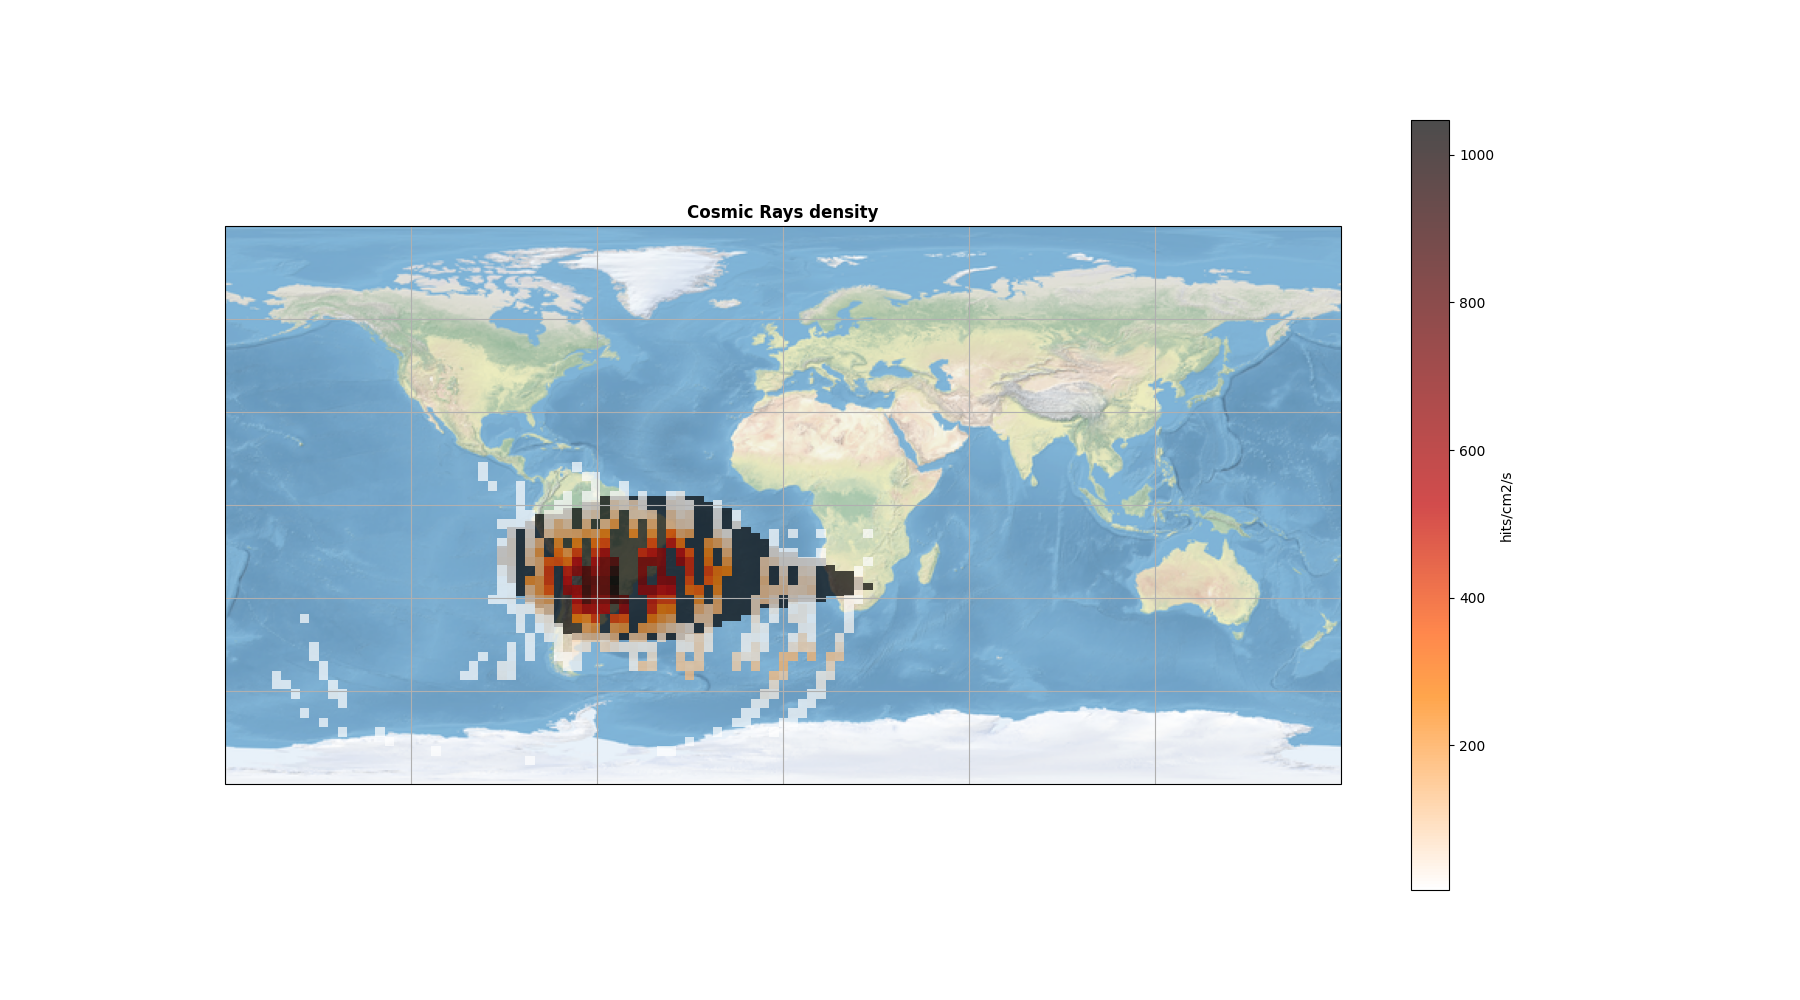

In [16]:
#%matplotlib widget
plt.close('all')
fig = plt.figure(figsize=(18, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax = plt.axes(projection=ccrs.Orthographic(-45, -23))
ax.stock_img()
ax.gridlines()

data_plot = detections

lon_min, lon_max = -180, 180
lat_min, lat_max = -90, 90

# Plot SAA mask
x = data_SAA['longitude']
y = data_SAA['latitude']
c = data_SAA['SAA_FLAG']
#cc = plt.scatter(x,y,c = c, s = 100, alpha = 0.1, marker = 'o', edgecolor='none', transform=ccrs.Geodetic())

SAA_map_bins_lon = 3
SAA_map_bins_lat = 2
x_bins_SAA = np.arange(lon_min, lon_max,SAA_map_bins_lon)
y_bins_SAA = np.arange(lat_min, lat_max,SAA_map_bins_lat)

ret_SAA = binned_statistic_2d(x, y, c, statistic='median', bins=[x_bins_SAA, y_bins_SAA])
cmap = ListedColormap(['none', 'black'])
SAA_mask = ax.imshow(ret_SAA.statistic.T, origin='lower', cmap = cmap, alpha = 0.7, extent=(lon_min, lon_max, lat_min, lat_max)) # Supported values for interplotation are 'none', 'antialiased', 'nearest', 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos', 'blackman'.


x = data_plot['LONGITUDE']
y = data_plot['LATITUDE']
c = data_plot['density_cosmics']

#cr = plt.scatter(x,y,c = c, s = 5, alpha = 0.7, marker = 'o', transform=ccrs.Geodetic())#, label = labels[i])
#plt.colorbar(cr)


x_bins = np.arange(lon_min, lon_max,3)
y_bins = np.arange(lat_min, lat_max,3)

ret = binned_statistic_2d(x, y, c, statistic='median', bins=[x_bins, y_bins])
SAA_map_plot = ax.imshow(ret.statistic.T, origin='lower', alpha = 0.7, cmap = 'gist_heat_r', extent=(lon_min, lon_max, lat_min, lat_max), interpolation='nearest') # Supported values for interplotation are 'none', 'antialiased', 'nearest', 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos', 'blackman'.
plt.colorbar(SAA_map_plot, label = 'hits/cm2/s' )

# #plt.title('June 28th, at 08:40:00, SAA_FLAG is False in MPS_PRE_VISIT')
# #plt.legend(frameon=True,bbox_to_anchor=(0.7,0),markerscale=1)
# #save_folder = '/Users/alexisheitzmann/Documents/CHEOPS/Code/SSA_mismapping/imagette_mapping/AU_Mic_5_sec_visits/'
# name_addition = 'all'
# save_name = 'map_CR_detections_'+ name_addition + '_' + np.min(full_orb_res_err.index).strftime("%Y-%m-%d") + '_to_' + np.max(full_orb_res_err.index).strftime("%Y-%m-%d") + '.png'
#title = str(len(data_plot)) + ' detections from ' + np.min(full_orb_res_err.index).strftime("%Y-%m-%d") + ' to ' + np.max(full_orb_res_err.index).strftime("%Y-%m-%d")
title = 'Cosmic Rays density'
plt.title(title, weight = 'bold')
plt.savefig("CR_density_" + visit_type + "_binned.png", transparent = True, dpi = 600,format = 'png')
# plt.savefig(save_name, transparent = True, dpi = 600,format = 'png')
# #plt.show()

# TESTS

In [ ]:
median_imagette = np.nanmedian(reshaped_masked_imagettes, axis=(0)) # median

plt.figure()
plt.imshow(median_imagette)
plt.colorbar()
plt.show()
# unique_values = np.unique(median_imagette)
# if (len(unique_values) == 1) & (np.unique(unique_values[0]) == 0): # If the only value is 0 for all pixels of the image
#     image_for_mask = median_imagette
#     med_or_mean = 'median'

# TO DO/IMPLEMENT

- Give this to Andrea to work out the real time sampled by one exposure

time: 1.0 + 0.25 sec

exp time
read out mode
size of image + imagette
rep period 


- Recompute the 2 lines-element from X,Y,Z or POS/VEL to get better position on the mmap

- Check to consistency between MJD in the imagette and JD in the restituted orbit file
- Adapt the main loop to directly fetch the restituted orbit files and concatenate them once we have the script on the compute node
- To cicumvent the double identification of a cosmic for complex patterns, we can check whether a all pixels of a contours are also present in another, larger contour. If yes, we can remove the detections and the contour associated to the snaller list. To test and add as a condition when doing the contour detection
- Mean or median in different cases
- For subArrays in science images:
  - Remove the ones with straylight
  - Fit the noise? 